In [1]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import datetime as dt
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from datetime import date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_absolute_error as mae
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import load_model
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [2]:
btc_input_df = pd.read_csv("data/FBTC-USD-mar-2017-to-06-feb-2023.csv")

btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2168 entries, 0 to 2167
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            2168 non-null   object 
 1   Close           2168 non-null   float64
 2   High            2168 non-null   float64
 3   Low             2168 non-null   float64
 4   Open            2168 non-null   float64
 5   Volume          2168 non-null   float64
 6   n-transactions  2168 non-null   int64  
 7   MKTCP           2168 non-null   float64
 8   HRATE           2168 non-null   float64
 9   DIFF            2168 non-null   float64
 10  AVBLS           2168 non-null   float64
dtypes: float64(9), int64(1), object(1)
memory usage: 186.4+ KB


In [3]:
btc_input_df['n-transactions'] = btc_input_df['n-transactions'].astype(float)
# Convert 'Date' to datetime and set as index (optional)
btc_input_df['Date'] = pd.to_datetime(btc_input_df['Date'])
btc_input_df.set_index('Date', inplace=True)

btc_input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2168 entries, 2017-03-01 to 2023-02-05
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Close           2168 non-null   float64
 1   High            2168 non-null   float64
 2   Low             2168 non-null   float64
 3   Open            2168 non-null   float64
 4   Volume          2168 non-null   float64
 5   n-transactions  2168 non-null   float64
 6   MKTCP           2168 non-null   float64
 7   HRATE           2168 non-null   float64
 8   DIFF            2168 non-null   float64
 9   AVBLS           2168 non-null   float64
dtypes: float64(10)
memory usage: 186.3 KB


In [4]:
# Please note that to improve model accuracy you should also include the features from sentiment analysis from news or social media
# Features
# Close: Final trading price at the end of the period.
# High: Highest price reached during the period.
# Low: Lowest price reached during the period.
# Open: Starting price at the beginning of the period.
# Volume: Total amount traded during the period.
# n-transactions: Number of trades or transactions during the period.
# MKTCP (Market Capitalization): Total market value of the cryptocurrency.
# HRATE (Hash Rate): Computational power used for mining or transactions.
# DIFF (Mining Difficulty): Challenge level for mining new blocks.
# AVBLS (Available Block Size): Size of blocks available for transactions
btc_input_df.head()

,Close,High,Low,Open,Volume,n-transactions,MKTCP,HRATE,DIFF,AVBLS
Date,,,,,,,,,,
2017-03-01,1222.500000,1222.500000,1179.689941,1180.040039,229056992.0,315883.0,1.989809e+10,3155225.442,4.410000e+11,0.979146
2017-03-02,1251.010010,1262.130005,1215.619995,1224.680054,368275008.0,329428.0,2.050876e+10,3440072.183,4.410000e+11,0.955612
2017-03-03,1274.989990,1280.310059,1250.709961,1250.709961,315739008.0,337310.0,2.089075e+10,3458650.323,4.460000e+11,0.985290
2017-03-04,1255.150024,1279.400024,1230.510010,1277.430054,183270000.0,268875.0,2.051548e+10,3069265.850,4.610000e+11,0.986085
2017-03-05,1267.119995,1267.290039,1238.060059,1254.290039,134127000.0,280739.0,2.062121e+10,3367030.447,4.610000e+11,0.983301


In [5]:
# Select features
# Please note that to improve model accuracy you should also include the features from sentiment analysis from news or social media
features = ['Close', 'High', 'Low', 'Open', 'Volume','MKTCP']

data = btc_input_df[features]

In [6]:
# Handle missing values if any
data = data.dropna()

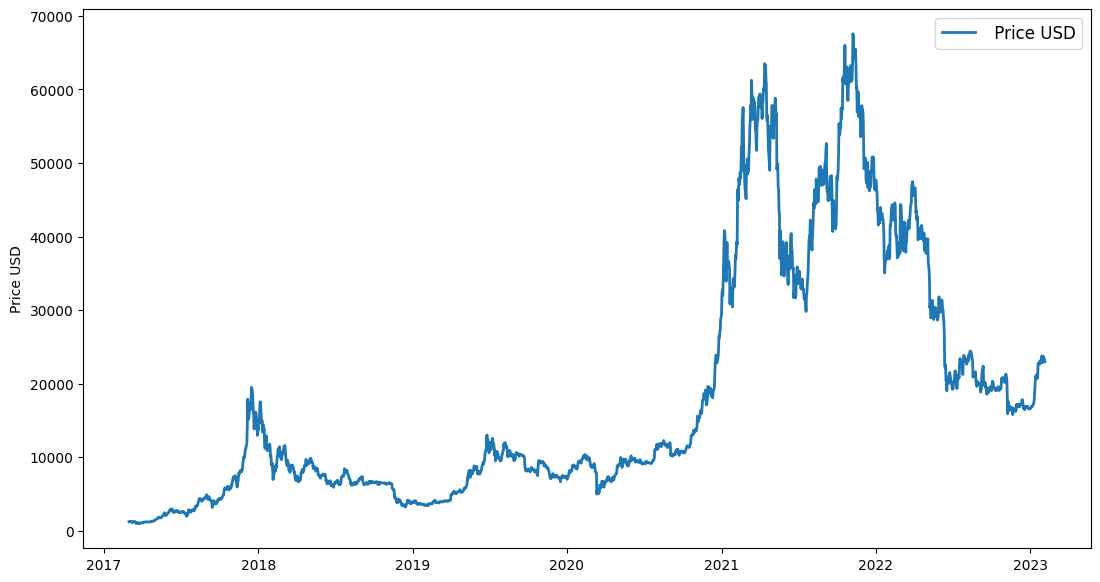

In [7]:
# btc_input_df_datetype.shape
closing_price = data['Close']
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(closing_price, label=' Price USD', linewidth=2)
# ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=10)
ax.set_title('', fontsize=12)
ax.legend(loc='best', fontsize=12)

In [8]:
# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [9]:
# Creates a sequence of dataset for time series prediction.
def create_dataset(data, time_step=30):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        y.append(data[i + time_step, 0])  # 'Close' is the target variable
    return np.array(X), np.array(y)

time_step = 30
X, y = create_dataset(scaled_data, time_step)

# Reshape for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split into training and testing sets
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("trainX: ", X_train.shape)
print("trainY: ", y_train.shape)
print("testX: ", X_test.shape)
print("testY", y_test.shape)

trainX:  (1709, 30, 6)
trainY:  (1709,)
testX:  (428, 30, 6)
testY (428,)


In [10]:
# Build the LSTM model
model = Sequential()
# Add the first LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
# Output layer to predict the final value
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['mean_absolute_error'])

In [11]:
# Define a callback to save the model with the best validation loss
checkpoint = ModelCheckpoint(
    'best_model.keras',       # Path to save the best model
    save_best_only=True        # Save only the model with the best validation loss
)

# Define a callback to stop training early if the validation loss does not improve
early_stopping = EarlyStopping(
    monitor='val_loss',      # Monitor validation loss
    patience=10              # Number of epochs to wait for improvement
)

# Train the model with the defined callbacks
history = model.fit(
    X_train,                 # Training data
    y_train,                 # Training labels
    epochs=50,               # Number of epochs to train
    batch_size=32,           # Batch size for training
    validation_split=0.2,    # Fraction of data to be used as validation set
    callbacks=[checkpoint, early_stopping]  # Callbacks for model checkpointing and early stopping
)


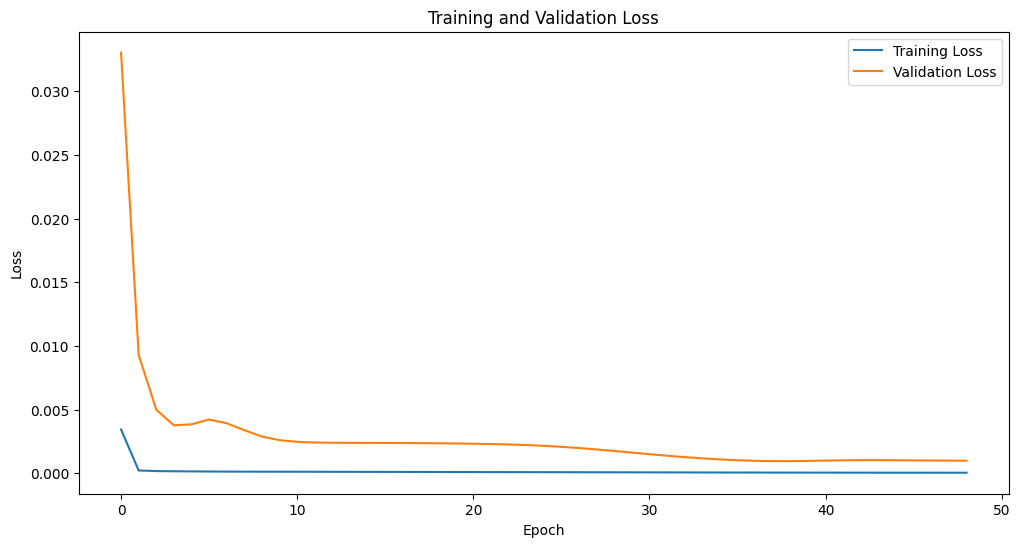

In [13]:
# Extract training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot loss curves
plt.figure(figsize=(12, 6))

# Plot training loss
plt.plot(train_loss, label='Training Loss')

# Plot validation loss
plt.plot(val_loss, label='Validation Loss')

# Add title and labels
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Show plot
plt.show()

In [14]:
# Predicting the prices
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]

# Inverse transform y_test
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1))[:, 0]


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


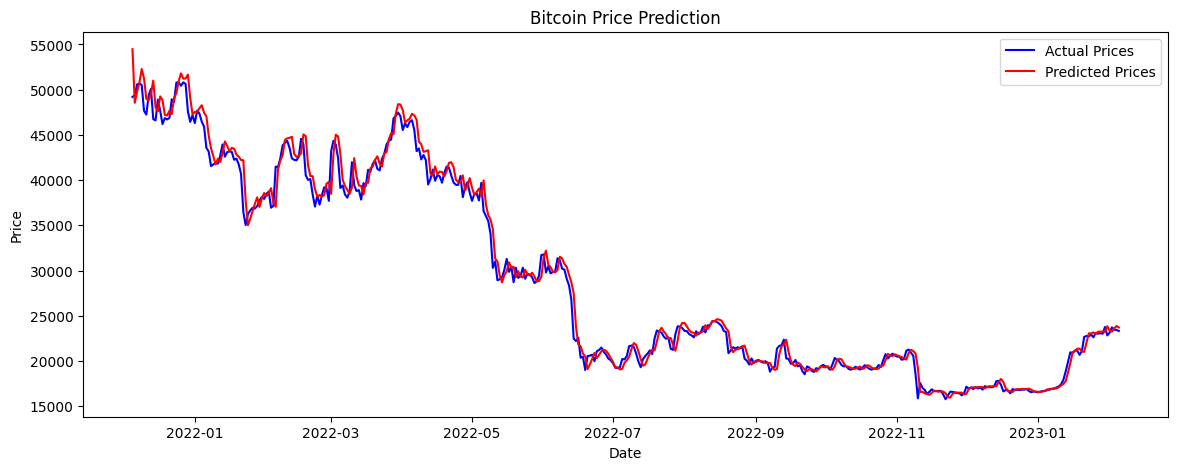

In [15]:
# Plotting the results
plt.figure(figsize=(14, 5))
plt.plot(btc_input_df.index[-len(y_test):], y_test, color='blue', label='Actual Prices')
plt.plot(btc_input_df.index[-len(y_test):], predictions, color='red', label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Bitcoin Price Prediction')
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#Please Note that play around with Hyper-Parameters for better results and good insights..
# Assuming predictions and y_test are numpy arrays

# Assuming y_test and predictions are your actual and predicted values
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100

# Calculate residuals
residuals = y_test - predictions
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Calculate mean of residuals
mean_residuals = np.mean(residuals)

print(f"Mean of Residuals: {mean_residuals:.4f}")

Root Mean Squared Error (RMSE): 1308.4374
Mean Absolute Error (MAE): 898.3439
Mean Absolute Percentage Error (MAPE): 3.08%
Mean of Residuals: -456.9134


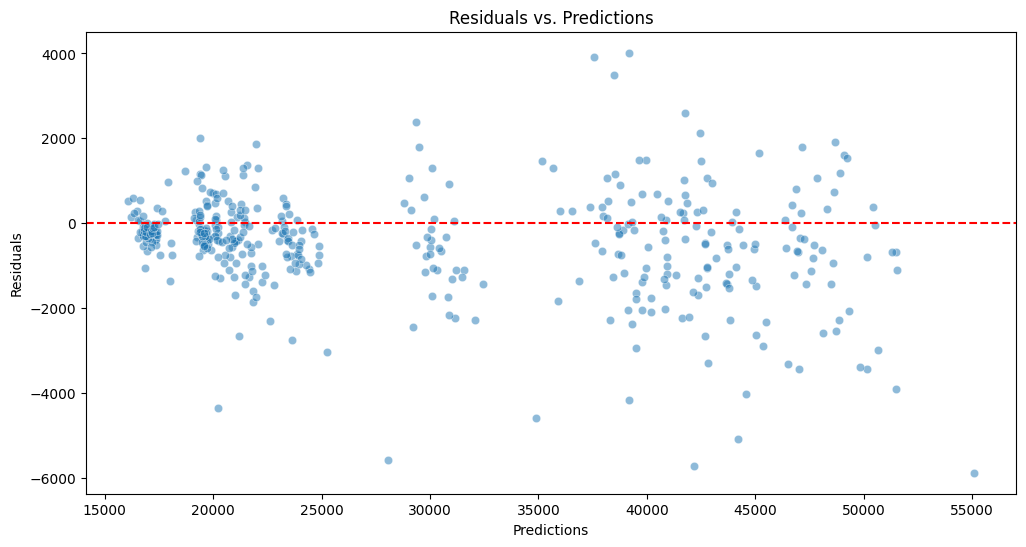

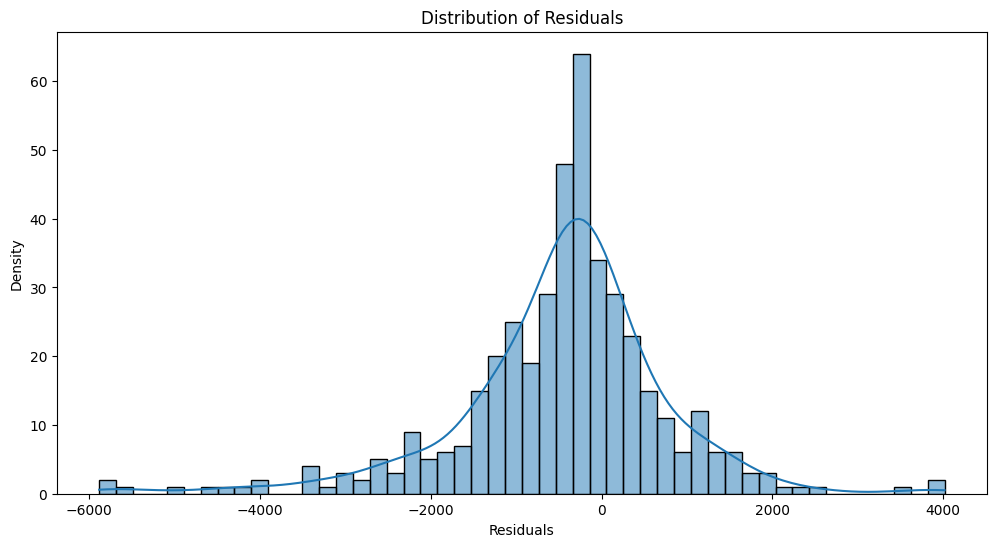

In [24]:



# Plot residuals vs. predictions
plt.figure(figsize=(12, 6))
sns.scatterplot(x=predictions, y=residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

# Plot distribution of residuals with KDE
plt.figure(figsize=(12, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.show()

In [20]:
# This is the code to load the best saved model after multiple runs
# Load the saved model
saved_model = load_model('best_model.keras')  # or your new model if applicable

# Make predictions using the loaded model
predictions = saved_model.predict(X_test)

# Inverse transform predictions
# Concatenate with zeros to match the scaled_data shape
predictions = scaler.inverse_transform(
    np.concatenate(
        (predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))),
        axis=1
    )
)[:, 0]

rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
# Calculate R-squared score
r2 = r2_score(y_test, predictions)
# Calculate residuals
residuals = y_test - predictions
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"R-squared Score (R²): {r2}")
# Calculate mean of residuals
mean_residuals = np.mean(residuals)

print(f"Mean of Residuals: {mean_residuals:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step
Root Mean Squared Error (RMSE): 1308.4374
Mean Absolute Error (MAE): 898.3439
Mean Absolute Percentage Error (MAPE): 3.08%
R-squared Score (R²): 0.9857970122261598
Mean of Residuals: -456.9134


In [19]:
# Print the model summary to inspect its architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 98,705 (385.57 KB)

 Trainable params: 32,901 (128.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 65,804 (257.05 KB)